In [28]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np

**Data Taken From:** https://www.kaggle.com/wordsforthewise/lending-club </br>
**Model is From:** https://www.kaggle.com/benesalvatore/predict-default-using-logisitic-regression

 Here we are defining a list of feature column names to be used as input variables for the model,'loan_amnt' represents the loan amount granted,'annual_inc' represents the annual income of the borrower,'term' represents the loan term (e.g., 36 months or 60months),
 'emp_length' represents the length of employment of the borrower (e.g., number of years employed).

In [29]:
features = ['loan_amnt', 'annual_inc', 'term', 'emp_length']

Read the CSV file 'accepted_2007_to_2018Q4.csv' into a pandas DataFrame 'a' where,'usecols' parameter is used to select specific columns to load into the DataFrame,'features' contains the list of columns you want to include as input features for the model,'loan_status' is added explicitly because it's the target variable that the model will predict.


In [30]:
a = pd.read_csv('accepted_2007_to_2018Q4.csv', usecols=features+['loan_status'])

The given line selects rows from the DataFrame 'a' where the 'loan_status' column is either 'Fully Paid' or 'Charged Off',
and to create an independent copy of the filtered data to prevent potential SettingWithCopyWarning during modifications.

In [31]:
full_set = a.query("loan_status in ('Fully Paid', 'Charged Off')").copy()

Dropping the rows from the 'full_set' DataFrame where the 'emp_length' column contains missing (NaN) values,
retaining only rows with valid employment length information which makes sure there are no empty rows or missing data while analysising the data.

In [32]:
full_set = full_set.dropna(subset=['emp_length'])

# Build the model - Logistic Regression

1. Transform our Label *loan_status* and other columns

This code transforms the field loan_status to numeric values where 'Fully Paid' is transformed to 1 and 'Charged Off' is transformed to 0 which makes easier to  analysis and similarly months which is a string is converted to intergers i.e '36 months' is converted to 36 and 
'60 months' is convereted to 60 which makes it better for the data analysis.


In [33]:
full_set['loan_status'] = full_set['loan_status'].replace(
    {
        'Fully Paid': 1,
        'Charged Off': 0
    }
)

full_set['term'] = full_set['term'].replace(
    {
        ' 36 months': 36,
        ' 60 months': 60
    }
)

/var/folders/9t/whqg56fd781btsd3zxp9xpf40000gn/T/ipykernel_41351/2571681893.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_set['loan_status'] = full_set['loan_status'].replace(
/var/folders/9t/whqg56fd781btsd3zxp9xpf40000gn/T/ipykernel_41351/2571681893.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_set['term'] = full_set['term'].replace(


Here, we extract the numerical portion of the 'emp_length' column by splitting each value on a space and keeping the first part (e.g,'10+ years' becomes '10+'). Next we are cleaning the extract values by removeming the '+' and replacing it with empty space '' and replacing '<' by 0 to handle cases like (e.g,'< 1 year' (e.g., '<' becomes '0').

In [34]:
full_set['emp_length'] = full_set['emp_length'].map(lambda x: x.split(' ')[0])
full_set['emp_length'] = full_set['emp_length'].map(lambda x: str(x).replace('+', '').replace('<', '0'))

**Build Model**

Next we are listing of all column from the 'full_set' Dataframe to use as a potential feature for the model and also we are removing the 'loan_status' from the feature list, as it is the target variable and it shouldn't be included as a predictor.

In [35]:
model_features = list(full_set.columns)
model_features.remove('loan_status')

After cleaning the data, we can get a overview of the data set by using the head() function which dispays the first few rows of the data set which gives clear information to conduct the analysis.

In [36]:
full_set.head()

,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36,10,55000.0,1
1,24700.0,36,10,65000.0,1
2,20000.0,60,10,63000.0,1
4,10400.0,60,3,104433.0,1
5,11950.0,36,4,34000.0,1


Next we are splitting the 'full_set' DataFrame into Training and Testing sets for the better model training and evalution.Here "X_train" and "X_test" will be consisting of feature data i.e input variables,where as "y_train" and "y_test" will contain the targetted varibles i.e 'loan_status' for model prediction.
The data is split using the "train_test_split" function where,
'Full_set[model_features]' this selects the feature columns for training and testing,'full_set'['loan_status'] is the target variable which the model will learn to predict,'random_state=42' ensures reproducibility of the split, so the data is split in the same way each time the code runs.


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    full_set[model_features],
    full_set['loan_status'],
    random_state=42
)

Here we are initialize the Logistic Regression model, where we will be predictting the target variable ('loan_status') and we also initalize MinMaxScaler() which will be used to scale the features to a range between 0 and 1 which is important to standardise the range of independent variables before training the model, especially for the alogrithms like logistic regeression that can be sensitive to the scale of the features.

In [38]:
model = LogisticRegression()
scaler = MinMaxScaler()

 Next we will be creating a pipeline that first applies the scaling transformation and then fits the Logistic Regression model, where "scaler" steps the scales features using the MinMaxScaler before the model is trained and the "model" steps applies the logistic Regression model to the scaled features for training or prediction.


In [39]:
pipeline = Pipeline([('scaler', scaler), ('model', model)])

Here we are fitting the pipeline to the training data where The 'fit' method applies the transformations and trains the logistic regeression model sequentially.Firstly, it scales the features in 'X_train' using the MinMaxScaler, then we fit the logistic regression model using the scaled features and the corresponding target variable 'Y_train'.


In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

**Test Model**

ROC-AUC-score:  0.6342068796098207


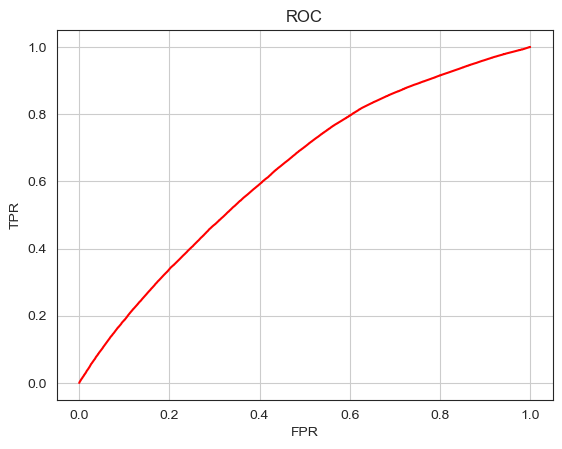

In [41]:
test_probas = pipeline.predict_proba(X_test)[:,1]

fpr, tpr, tresholds = roc_curve(y_test, test_probas)
plt.plot(fpr, tpr, color='red')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

print('ROC-AUC-score: ', roc_auc_score(y_test, test_probas))

In [42]:
def _compute_accuracy_for_thresholds(data: pd.core.frame.DataFrame):
    """
    Compute Classifier's Accuracy for various thresholds
    """
    
    thresholds = np.linspace(0, 1, 100)
    
    accuracies = []
    
    for threshold in thresholds:
        preds = data['preds'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = accuracy_score(data['labels'].values, preds)
        accuracies.append(accuracy_)
    
    return accuracies, thresholds

In [43]:
X_test['preds'] = test_probas
X_test['labels'] = y_test

In [44]:
accuracies, thresholds = _compute_accuracy_for_thresholds(X_test)

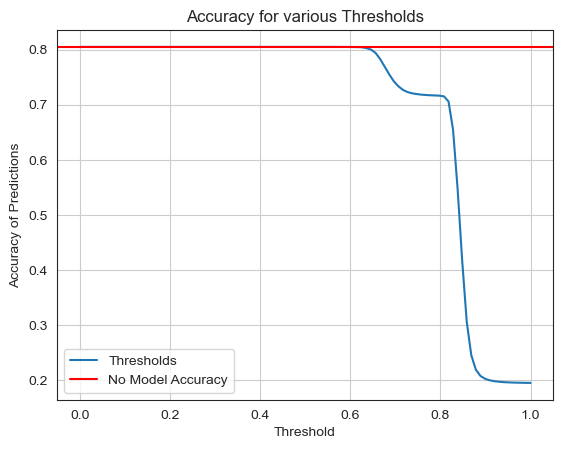

In [45]:
plt.plot(thresholds.reshape(-1, 1), accuracies, label='Thresholds')
plt.axhline(
    (X_test['labels'].sum()) / len(X_test), color='red', label='No Model Accuracy')
plt.grid()
plt.title('Accuracy for various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy of Predictions')
plt.legend()
plt.show()

In [46]:
accuracy_score(X_test['labels'].values, list(map(lambda x: 1 if x > 0.7 else 0, X_test['preds'])))

0.7393148089674771

**Save Pipeline**

In [47]:
with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [48]:
model = pickle.load(
    open('model.pkl', 'rb')
)